In [9]:
# importing required libraries and packages 

import numpy as np
import pandas as pd
import xgboost as xgb
import petroeval as pet
import sklearn.metrics as sklm
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split

### Getting Data

The train data set comprise well logs from a total of 98 wells from the North Sea, while the open test data is made up of 10 wells, Only the gamma ray (GR) log is present in all the wells.

In [106]:
traindata = pd.read_csv('./data/train.csv', sep=';')
testdata = pd.read_csv('./data/leaderboard_test_features.csv.txt', sep=';')

### Data Exploration and Visualization

Here, the data is investigated to understand it better (shape and form). Since the data is a combination of 98 different wells, it will be time intensive to make visualizations of each of the wells, so a more combined approach into looking at the wells is taken. Both train and test data are explored simultaneously.

- Basic information check on wells and data
- Visualizing the percentage of each logs present in all wells
- Visualizing the percentage OF missing values of each logs present in all wells
- Spatial distribution of wells according to their coordinates
- Visualizing some log plots

In [107]:
traindata.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-13,494.528,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,...,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0
1,15/9-13,494.680,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,...,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0
2,15/9-13,494.832,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,...,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0
3,15/9-13,494.984,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,...,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0
4,15/9-13,495.136,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,...,57.483765,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0


In [108]:
traindata.shape, testdata.shape

((1170511, 29), (136786, 27))

With over 1million training data points, safe to call this "big data". Also, could be seen that the test data set has two logs lesser than the train data. Let's investigate that.

In [111]:
number = 0
logs = []
for log in traindata.columns:
    if log not in testdata.columns:
        logs.append(log)
        number += 1

print(f'{number} logs not in test data:')
print(logs)

2 logs not in test data:
['FORCE_2020_LITHOFACIES_LITHOLOGY', 'FORCE_2020_LITHOFACIES_CONFIDENCE']


In [112]:
traindata.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF',
       'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC',
       'ROPA', 'RXO', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
       'FORCE_2020_LITHOFACIES_CONFIDENCE'],
      dtype='object')

In [113]:
traindata.dtypes

WELL                                  object
DEPTH_MD                             float64
X_LOC                                float64
Y_LOC                                float64
Z_LOC                                float64
GROUP                                 object
FORMATION                             object
CALI                                 float64
RSHA                                 float64
RMED                                 float64
RDEP                                 float64
RHOB                                 float64
GR                                   float64
SGR                                  float64
NPHI                                 float64
PEF                                  float64
DTC                                  float64
SP                                   float64
BS                                   float64
ROP                                  float64
DTS                                  float64
DCAL                                 float64
DRHO      

From above data types, there are three categorical logs denoted as 'object'. Getting more info on these logs will provide better insight to choose a better encoding technique.

In [114]:
print(f'Number of wells in data: {len(np.unique(traindata.WELL))}')

Number of wells in data: 98


In [115]:
# checking more info on the categorical logs (FORMATION AND GROUP)

print(f'Unique formation count: {len(dict(traindata.FORMATION.value_counts()))}')
print(f'Unique group count: {len(dict(traindata.GROUP.value_counts()))}')

Unique formation count: 69
Unique group count: 14


In [117]:
traindata.GROUP.value_counts()

HORDALAND GP.       293155
SHETLAND GP.        234028
VIKING GP.          131999
ROGALAND GP.        131944
DUNLIN GP.          119085
NORDLAND GP.        111490
CROMER KNOLL GP.     52320
BAAT GP.             35823
VESTLAND GP.         26116
HEGRE GP.            13913
ZECHSTEIN GP.        12238
BOKNFJORD GP.         3125
ROTLIEGENDES GP.      2792
TYNE GP.              1205
Name: GROUP, dtype: int64

In [116]:
traindata.FORMATION.value_counts()

Utsira Fm.               172636
Kyrre Fm.                 94328
Lista Fm.                 71080
Heather Fm.               65041
Skade Fm.                 45983
                          ...  
Broom Fm.                   235
Intra Balder Fm. Sst.       177
Farsund Fm.                 171
Flekkefjord Fm.             118
Egersund Fm.                105
Name: FORMATION, Length: 69, dtype: int64

#### Checking for the percentage of each logs present in all wells

For train data

Text(0, 0.5, 'Well presence (\\%)')

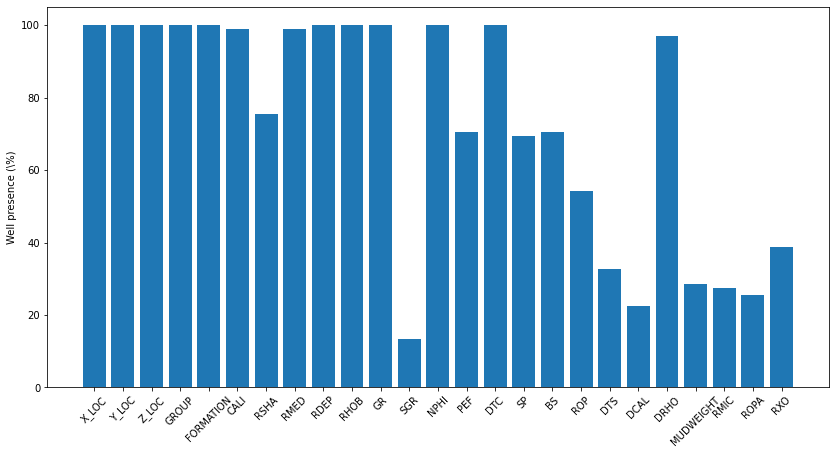

In [118]:
# this code is extracted from Matteo Niccoli github EDA repo for the FORCE competition: 
# https://github.com/mycarta/Force-2020-Machine-Learning-competition_predict-lithology-EDA/blob/master/Interactive_data_inspection_and_visualization_by_well.ipynb

occurences = np.zeros(25)
for well in traindata['WELL'].unique():
    occurences += traindata[traindata['WELL'] == well].isna().all().astype(int).values[2:-2]
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(occurences.shape[0]), height=(traindata.WELL.unique().shape[0]-occurences)/traindata.WELL.unique().shape[0]*100.0)
ax.set_xticklabels(traindata.columns[2:-2], rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Well presence (\%)')

Text(0, 0.5, 'Well presence (\\%)')

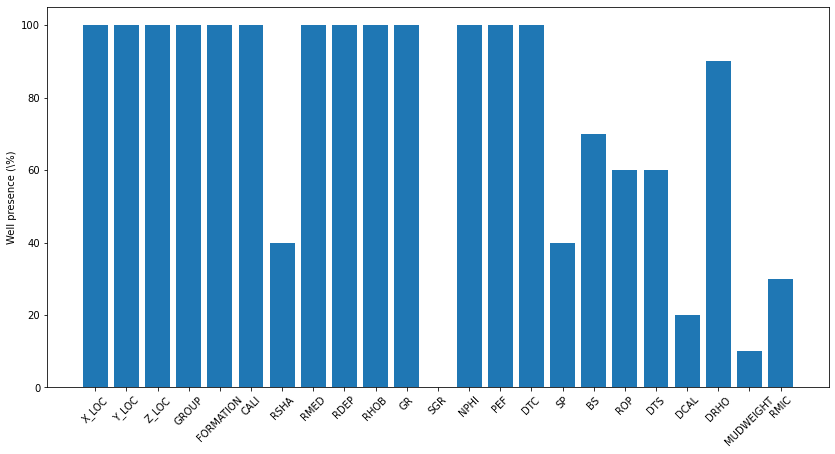

In [121]:
# this code is extracted from Matteo Niccoli github EDA repo for the FORCE competition: 
# https://github.com/mycarta/Force-2020-Machine-Learning-competition_predict-lithology-EDA/blob/master/Interactive_data_inspection_and_visualization_by_well.ipynb

occurences = np.zeros(23)
for well in testdata['WELL'].unique():
    occurences += testdata[testdata['WELL'] == well].isna().all().astype(int).values[2:-2]
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(occurences.shape[0]), height=(testdata.WELL.unique().shape[0]-occurences)/testdata.WELL.unique().shape[0]*100.0)
ax.set_xticklabels(testdata.columns[2:-2], rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Well presence (\%)')

Logs are presently different in both train and test data, as we can see, the SGR log is absent in all test logs

While figure above shows the log presence based on appearance on all wells, the below shows the percentage of logs based on missing values/actual data present

In [132]:
train_well_items = dict(100 - (traindata.isna().sum()/traindata.shape[0]) * 100)
test_well_items = dict(100 - (testdata.isna().sum()/testdata.shape[0]) * 100)

In [133]:
train_well_items = {log:value for log, value in train_well_items.items() if value != 100.0}
test_well_items = {log:value for log, value in test_well_items.items() if value != 100.0}

In [134]:
train_well_items

{'X_LOC': 99.07946187605242,
 'Y_LOC': 99.07946187605242,
 'Z_LOC': 99.07946187605242,
 'GROUP': 99.89081691671416,
 'FORMATION': 88.29622276082839,
 'CALI': 92.49242424889643,
 'RSHA': 53.878177992346934,
 'RMED': 96.66871990096632,
 'RDEP': 99.05895801064663,
 'RHOB': 86.22234220780497,
 'SGR': 5.925019072866462,
 'NPHI': 65.3910129849271,
 'PEF': 57.38450984228256,
 'DTC': 93.09164971538073,
 'SP': 73.83501735566773,
 'BS': 58.32128019300972,
 'ROP': 45.712599027262456,
 'DTS': 14.91767270875711,
 'DCAL': 25.530131711705394,
 'DRHO': 84.3953623673763,
 'MUDWEIGHT': 27.0096564662784,
 'RMIC': 15.049837207851951,
 'ROPA': 16.430857975704626,
 'RXO': 27.972996409260574,
 'FORCE_2020_LITHOFACIES_CONFIDENCE': 99.98470753371818}

Text(0, 0.5, 'Data presence (\\%)')

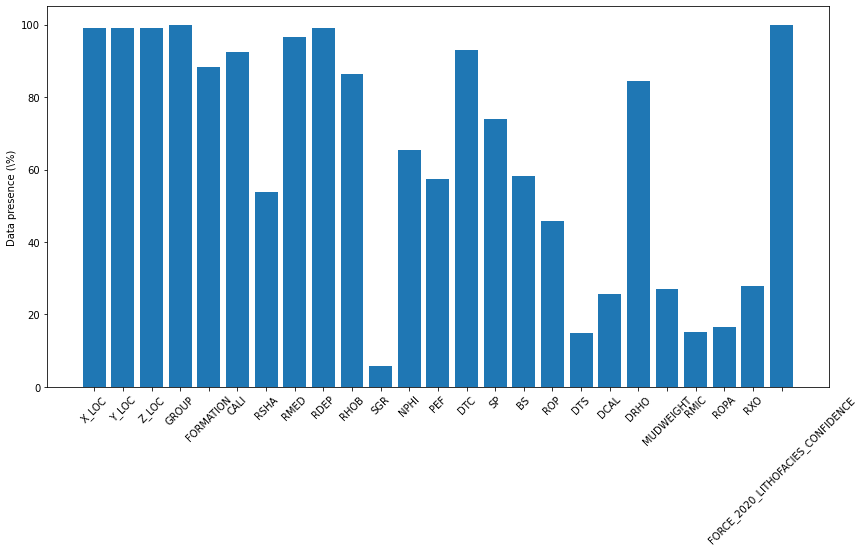

In [136]:
occurences = np.zeros(len(train_well_items))
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(occurences.shape[0]), height=train_well_items.values())
ax.set_xticklabels(train_well_items.keys(), rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Data presence (\%)')

Text(0, 0.5, 'Data presence (\\%)')

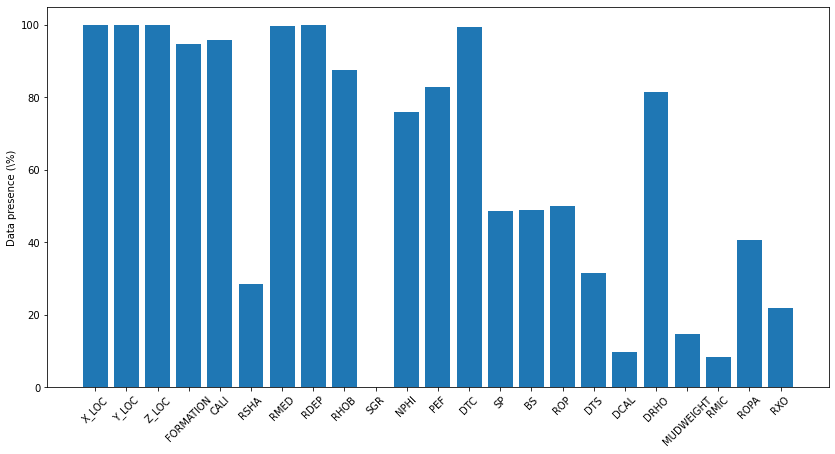

In [135]:
occurences = np.zeros(len(test_well_items))
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(occurences.shape[0]), height=test_well_items.values())
ax.set_xticklabels(test_well_items.keys(), rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Data presence (\%)')

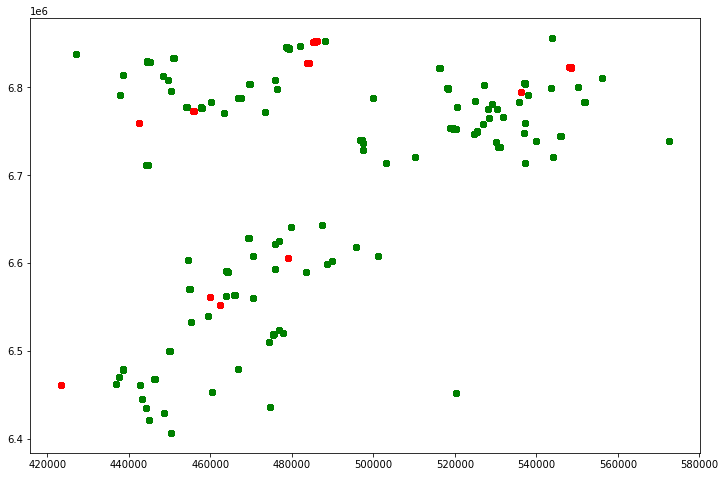

In [140]:
# spatial distribution of both train and test wells

fig = plt.figure(figsize=(12,8))
plt.scatter(traindata.X_LOC, traindata.Y_LOC, c='g')
plt.scatter(testdata.X_LOC, testdata.Y_LOC, c='r')
plt.show()

From the plot, we can see that the test wells are evenly distributed to cover the train wells spread. This makes it easier while preparing the data sets as we get to apply almost same techniques to both data sets.

While it might be impossible to view all train and test logs, let's take a look at a test well in close proximity to the train logs and compare log signatures

In [147]:
testdata.loc[testdata.WELL == '15/9-14']

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO
0,15/9-14,480.628001,423244.50000,6461862.5,-455.624420,NORDLAND GP.,NaN,19.203100,NaN,1.613886,...,35.525719,NaN,96.461990,NaN,NaN,-0.538873,0.130611,NaN,NaN,NaN
1,15/9-14,480.780001,423244.50000,6461862.5,-455.776428,NORDLAND GP.,NaN,19.203100,NaN,1.574376,...,36.158520,NaN,96.454399,NaN,NaN,-0.539232,0.130611,NaN,NaN,NaN
2,15/9-14,480.932001,423244.50000,6461862.5,-455.928436,NORDLAND GP.,NaN,19.203100,NaN,1.436627,...,36.873703,NaN,96.446686,NaN,NaN,-0.540830,0.130611,NaN,NaN,NaN
3,15/9-14,481.084001,423244.50000,6461862.5,-456.080444,NORDLAND GP.,NaN,19.203100,NaN,1.276094,...,37.304054,NaN,161.170166,NaN,NaN,-0.543943,0.130611,NaN,NaN,NaN
4,15/9-14,481.236001,423244.53125,6461862.5,-456.232422,NORDLAND GP.,NaN,19.203100,NaN,1.204704,...,37.864922,NaN,172.489120,NaN,NaN,-0.542104,0.130611,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20276,15/9-14,3563.948001,423282.50000,6461833.0,-3537.343262,VESTLAND GP.,Smith Bank Fm.,8.712281,3.1348,2.065150,...,50.611870,NaN,NaN,NaN,NaN,0.031030,NaN,NaN,NaN,3.135
20277,15/9-14,3564.100001,423282.53125,6461833.0,-3537.494873,VESTLAND GP.,Smith Bank Fm.,8.766216,3.1348,2.043545,...,51.336975,NaN,NaN,NaN,NaN,-0.003454,NaN,NaN,NaN,3.135
20278,15/9-14,3564.252001,423282.53125,6461833.0,-3537.646484,VESTLAND GP.,Smith Bank Fm.,8.794763,3.1348,2.074236,...,51.356167,NaN,NaN,NaN,NaN,-0.008872,NaN,NaN,NaN,3.135
20279,15/9-14,3564.404001,423282.53125,6461833.0,-3537.798096,VESTLAND GP.,Smith Bank Fm.,8.672709,3.1348,2.123846,...,51.669449,NaN,NaN,NaN,NaN,-0.004069,NaN,NaN,NaN,3.135


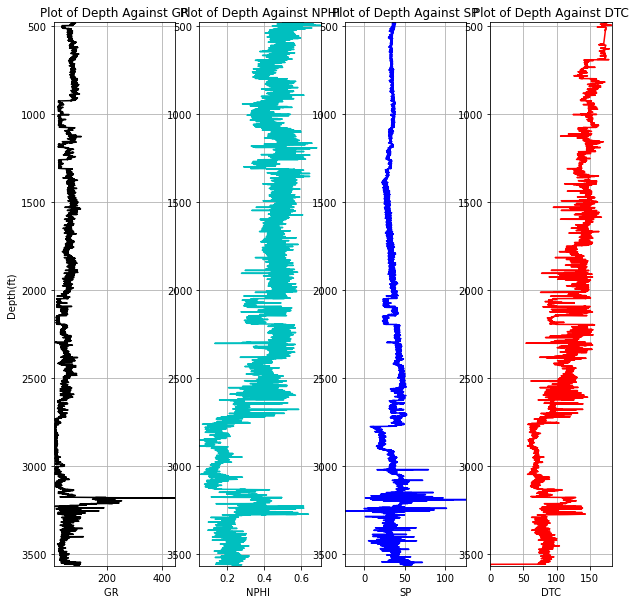

In [146]:
pet.four_plots(testdata.loc[testdata.WELL == '15/9-14'], x1='GR', x2='NPHI', x3='SP', x4='DTC',
               top=480, base=3565, depth='DEPTH_MD')

In [149]:
traindata.WELL.unique()

array(['15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A', '16/10-1',
       '16/10-2', '16/10-3', '16/10-5', '16/11-1 ST3', '16/2-11 A',
       '16/2-16', '16/2-6', '16/4-1', '16/5-3', '16/7-4', '16/7-5',
       '16/8-1', '17/11-1', '25/11-15', '25/11-19 S', '25/11-5',
       '25/2-13 T4', '25/2-14', '25/2-7', '25/3-1', '25/4-5', '25/5-1',
       '25/5-4', '25/6-1', '25/6-2', '25/6-3', '25/7-2', '25/8-5 S',
       '25/8-7', '25/9-1', '26/4-1', '29/6-1', '30/3-3', '30/3-5 S',
       '30/6-5', '31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9',
       '31/3-1', '31/3-2', '31/3-3', '31/3-4', '31/4-10', '31/4-5',
       '31/5-4 S', '31/6-5', '31/6-8', '32/2-1', '33/5-2', '33/6-3 S',
       '33/9-1', '33/9-17', '34/10-19', '34/10-21', '34/10-33',
       '34/10-35', '34/11-1', '34/11-2 S', '34/12-1', '34/2-4',
       '34/3-1 A', '34/4-10 R', '34/5-1 A', '34/5-1 S', '34/7-13',
       '34/7-20', '34/7-21', '34/8-1', '34/8-3', '34/8-7 R', '35/11-1',
       '35/11-10', '35/11-11', '35/11-12

In [152]:
traindata.loc[traindata.WELL == '15/9-15']

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
18270,15/9-15,485.256,436817.90625,6462991.5,-460.255005,NORDLAND GP.,NaN,NaN,1.567587,1.567587,...,46.064972,NaN,NaN,NaN,0.133007,NaN,NaN,-999.900024,65000,3.0
18271,15/9-15,485.408,436817.90625,6462991.5,-460.406982,NORDLAND GP.,NaN,NaN,1.570050,1.570050,...,46.067581,NaN,NaN,NaN,0.133007,NaN,NaN,-999.900024,65000,3.0
18272,15/9-15,485.560,436817.90625,6462991.5,-460.558990,NORDLAND GP.,NaN,NaN,1.553659,1.553659,...,46.070087,NaN,NaN,NaN,0.133007,NaN,NaN,-999.900024,65000,3.0
18273,15/9-15,485.712,436817.90625,6462991.5,-460.710999,NORDLAND GP.,NaN,NaN,1.541216,1.541216,...,46.072601,NaN,NaN,NaN,0.133007,NaN,NaN,-999.900024,65000,3.0
18274,15/9-15,485.864,436817.90625,6462991.5,-460.863007,NORDLAND GP.,NaN,NaN,1.540456,1.540456,...,44.937218,NaN,NaN,NaN,0.133007,NaN,NaN,-999.900024,65000,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35982,15/9-15,3199.520,436790.84375,6463021.0,-3173.941162,HEGRE GP.,Skagerrak Fm.,7.776711,0.987094,0.987094,...,21.762825,NaN,-0.723289,-0.011544,0.191722,NaN,NaN,-7.453425,30000,1.0
35983,15/9-15,3199.672,436790.84375,6463021.0,-3174.093262,HEGRE GP.,Skagerrak Fm.,7.779644,0.969350,0.969350,...,22.075161,NaN,-0.720356,-0.012000,0.191722,NaN,NaN,-7.518777,30000,1.0
35984,15/9-15,3199.824,436790.84375,6463021.0,-3174.245117,HEGRE GP.,Skagerrak Fm.,7.792982,0.962780,0.962780,...,NaN,NaN,-0.707018,-0.012083,0.191722,NaN,NaN,-7.584129,30000,1.0
35985,15/9-15,3199.976,436790.84375,6463021.0,-3174.397217,HEGRE GP.,Skagerrak Fm.,NaN,0.973905,0.973905,...,NaN,NaN,1899.866943,-0.013277,0.191722,NaN,NaN,-7.649461,30000,NaN


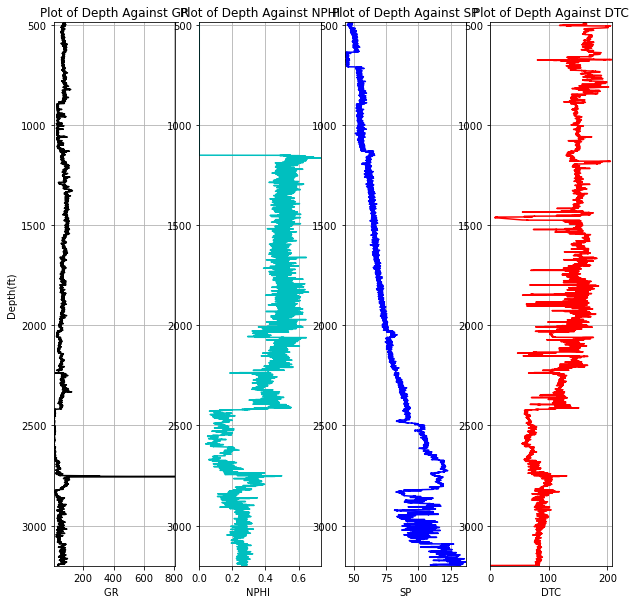

In [153]:
pet.four_plots(traindata.loc[traindata.WELL == '15/9-15'], x1='GR', x2='NPHI', x3='SP', x4='DTC',
               top=485, base=3201, depth='DEPTH_MD')